# Домашнее задание №4

Это домашнее задание можно выполнять целиком в этом ноутбуке, либо алгоритмы написать в отдельном файле и импортировать сюда, для использования. В папке data лежат два файла islands.fasta и nonIslands.fasta. В них хранятся прочтения из CpG островков и из обычных участков генома соответственно, этими данными нужно будет воспользоваться в первом задании.

In [28]:
from Bio import SeqIO
import numpy as np
import numpy.random as rdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

## Задача №1 (1)
Определите частоты генерации для каждого из нуклеотидов внутри CpG островков и вне их. Посчитайте так-же частоты для всех упорядоченных пар нуклеотидов и сравните частоту пары CG внутри островков и снаружи. Сделайте вывод. 

In [2]:
p_in_pairs = {a: {b: .0 for b in ['A', 'C', 'G', 'T']} for a in ['A', 'C', 'G', 'T']}
p_out_pairs = {a: {b: .0 for b in ['A', 'C', 'G', 'T']} for a in ['A', 'C', 'G', 'T']}


for record in SeqIO.parse("data/islands.fasta", "fasta"):
    for a in ['A', 'C', 'G', 'T']:
        for b in ['A', 'C', 'G', 'T']:
            p_in_pairs[a][b] += record.seq.count(a + b)

for a in ['A', 'C', 'G', 'T']:
    count = 0
    for b in ['A', 'C', 'G', 'T']:
        count += p_in_pairs[a][b]
    for b in ['A', 'C', 'G', 'T']:
        p_in_pairs[a][b] /= count

for record in SeqIO.parse("data/nonislands.fasta", "fasta"):
    for a in ['A', 'C', 'G', 'T']:
        for b in ['A', 'C', 'G', 'T']:
            p_out_pairs[a][b] += record.seq.count(a + b)

for a in ['A', 'C', 'G', 'T']:
    count = 0
    for b in ['A', 'C', 'G', 'T']:
        count += p_out_pairs[a][b]
    for b in ['A', 'C', 'G', 'T']:
        p_out_pairs[a][b] /= count


p_in_pairs['C']['G'], p_out_pairs['C']['G']

(0.21849631407787068, 0.028310225522135517)

In [3]:
p_in = {a: 0. for a in ['A', 'C', 'G', 'T']}
p_out = {a: 0. for a in ['A', 'C', 'G', 'T']}


for record in SeqIO.parse("data/islands.fasta", "fasta"):
    for a in ['A', 'C', 'G', 'T']:
        p_in[a] += record.seq.count(a)

count = 0
for a in ['A', 'C', 'G', 'T']:
    count += p_in[a]
for a in ['A', 'C', 'G', 'T']:
    p_in[a] /= count

for record in SeqIO.parse("data/nonislands.fasta", "fasta"):
    for a in ['A', 'C', 'G', 'T']:
        p_out[a] += record.seq.count(a)

count = 0
for a in ['A', 'C', 'G', 'T']:
    count += p_out[a]
for a in ['A', 'C', 'G', 'T']:
    p_out[a] /= count


p_in['C'], p_out['C']

(0.29639660831509845, 0.19613640750872205)

In [4]:
p_out

{'A': 0.28929861153616176,
 'C': 0.19613640750872205,
 'G': 0.1984481597792771,
 'T': 0.3161168211758391}

In [5]:
p_in

{'A': 0.20246225382932168,
 'C': 0.29639660831509845,
 'G': 0.29827680525164113,
 'T': 0.20286433260393874}

Получается, что внутри CG островков частота встретить пару нуклеотидов CG значительно выше.

## Задача №2 (2)
Напишите марковскую модель, которая имеет открытые состояния {A, T, G, C}, и скрытые состояния {+, -}. Когда модель в состоянии **+**, то вероятность генерации некоторого символа нуклеотида соответствует его частоте внутри CpG островков, вычислиному в первом задании, если состояние **-**, то частоте вне островков. Вероятность остаться внутри островка 0.95, а перейти в обычный геном 0.05. Для остальной части генома соответствующие вероятности 0.995 и 0.005. Саму модель можно реализовать в виде итератора, определив метод next, который возвращает пару - состояние и нуклеотид, который в этом состоянии произведен.    
Воспользуйтесь данной моделью для того чтобы сгенерировать набор из 20 последовательностей длинной от 1 000 до 100 000, причем к каждой последовательности должна прилагаться последовательность состояний.

In [8]:
class MarkovChain:
    def __init__(self, first_nucleotide, state, p_in, p_out) -> None:
        self.a = first_nucleotide
        self.state = state
        self.p_in = list(p_in.values())
        self.p_out = list(p_out.values())
        self.keys = ['A', 'C', 'G', 'T']
        

    def change_state(self):
        if self.state == "+" and rdm.rand() > 0.95:
            self.state = "-"
        elif self.state == "-" and rdm.rand() > 0.995:
            self.state = "+"

    def next_nucleotide(self):
        if self.state == "+":
            self.a = self.seq_in[self.i1]
            self.i1 += 1
        else:
            self.a = self.seq_out[self.i2]
            self.i2 += 1

    def __iter__(self):
        self.total = rdm.randint(1000, 100000)
        self.seq_in = rdm.choice(['A', 'C', 'G', 'T'], self.total, p=self.p_in)
        self.seq_out = rdm.choice(['A', 'C', 'G', 'T'], self.total, p=self.p_out)
        self.i1 = 0
        self.i2 = 0
        return self

    def __next__(self):
        if self.i1 + self.i2 < self.total:
            self.change_state()
            self.next_nucleotide()
            return self.a, self.state
        else:
            raise StopIteration
        
    def __len__(self):
        return self.total

In [10]:
mc = MarkovChain('T', '-', p_in=p_in, p_out=p_out)
seqs = [[] for _ in range(20)]
states = [[] for _ in range(20)]
for i in range(20):
    for a, state in mc:
        seqs[i].append(a)
        states[i].append(state)

print(''.join(seqs[0]))
print(''.join(states[0]))

AACGTCACTTGTGTACGAGGGTTCTCCTAAGTCTGTGGCTTAACCCAGTTTAGAGCAGGAGTCACTGATTATTAGAGTAATCTATTTAACACGTGATAAATCCTTCTGACGTCTGTGGTCTAATTTATTCTGTTTGAACTTTGACGTTTCATTTTCGGAACACCTTTAAAATTCTGCAAGAGATTACTTACGTGTTTTTATGACTAATGGGTTTGTTAATCAATGTGAAACGAATAGTTGAACAATGCTAGTGCATTCTGAAAATTGACTGTTACTTTAATGTCGTCGCTCTCAGGGAGTCCTAACTGATACTCCGCATTAAAATCTCGTCCGAAGTCAGATTTTTATAACCTAAGTGGAGATAAATTTACAAGGAACGGGTAAATCGTTACACATATCATAAACAATTTGGCCATTGTAGTCCACACTATATAAGGATTATCACCTCTTATTCGGAGTTAAATATAGACTACGCGGTCATGAAGTGCCCGATATGGTGCCGGACCTGCATTAAGAGAGCTACGTTATTTAAACCTATATAGTTTATAATCAACTGTAATTTAATTTTCATACTAATTCATAGAACCGATTGCTTGTTGAGGGATTGCTGTGCCTTCAACCAATATTAAAAAGTTAAACAAGGGTTTTGCTAAGCATTTATAGATCACTGATAGAGCAAAAAAGGAGGGTGTCCACTATGCGTCCACCCGGTTGATTCTTGTCTTTCGCAAACCGAGTGCTCACGGTCGTGTTATTTGTGCAAGGCCCAAGCTGGGAGACTTTAACTAATCATGGTTAGAGACTTATAATATGAGCTAGTGTAGCGCTTCGCCATACTTTACTGCTATCGACTAAGCCGGTTGGGACACTCCAGGATTGCCGAGCGCCTGGGGGACTTCTCATATATAGTAATCTCAGCAACGGTATTAAATCTTCGCGAGCTATAGGTCAATATAGCCAACAAGTCCTCCCCGCGATAGCATACGTGTTAAAGCCATTC

## Задача №3 (4)
Напишите алгоритм Витерби для восстановления последовательности скрытых состояний марковской модели из второго задаания. Воспользуйтесь им, воссстановив состояния тех последовательностей, которые вы получили во втором задании и посчитайте TP, TN, FP, FN по количеству правильно или ошибочно предсказанных позиций из CpG остравков. 

In [11]:
a = [[0.995, 0.005], 
     [0.05,  0.95 ]] # матрица переходов
# 0-state = "-"
# 1-state = "+"

def viterbi(obs, p_0, p_1, a):
    T1 = [[0, 0] for _ in range(len(obs))]
    T2 = [[0, 0] for _ in range(len(obs))]
    p = [p_0, p_1]
    T1[0][0] = np.log(.2)
    T1[0][1] = np.log(.8)
    for o in range(1, len(obs)):
        for i in range(2):
            #T1[o][i] = max(T1[o-1][0]*a[0][i], T1[o-1][1]*a[1][i])*p[i][obs[o]]
            #T2[o][i] = np.argmax([T1[o-1][0]*a[0][i], T1[o-1][1]*a[1][i]])
            T1[o][i] = max(T1[o-1][0] + np.log(a[0][i]), T1[o-1][1] + np.log(a[1][i])) + np.log(p[i][obs[o]])
            T2[o][i] = np.argmax([T1[o-1][0] + np.log(a[0][i]), T1[o-1][1] + np.log(a[1][i])])
    z = [0 for _ in range(len(obs))]
    z[-1] = np.argmax([T1[-1][0], T1[-1][1]])
    for i in reversed(range(1, len(obs))):
        z[i-1] = T2[i][z[i]]
    return z


In [12]:
true_states = []
pred_states = []
for i in range(20):
    k = len(seqs[i])//50
    for s, state in zip(np.array_split(seqs[i], k), np.array_split(states[i], k)):
        true_states += [1 if i == "+" else 0 for i in state]
        pred_states += viterbi(s, p_out, p_in, a)

In [13]:
tn, fp, fn, tp = confusion_matrix(true_states, pred_states, normalize='all').ravel()
print('TN={}, FP={}, FN={}, TP={}'.format(tn, fp, fn, tp))

TN=0.8493698694904339, FP=0.06299063363576338, FN=0.048069868675258615, TP=0.0395696281985441


Я не уверен, что это нормальный результат. У FN какое-то большое значение. Но вроде все сделал правильно

## Задача №4 (4)
Напишите алгоритм вперед назад для модели из второго задания. Пользуясь этим алгоритмом найдите вероятности того, что модель находилась в состоянии **+** для каждой позиции строк из второго задания. Устанавливая различные пороговые значения, определите позиции соответствующие CpG островкам и посчитайте TP. Постройте график зависимости TP от выбранного порогового значения. Есть ли пороговые значения при которых TP больше чем в задании №3?

In [15]:
def forward_backward(obs, p_0, p_1, a):
    f = [[0, 0] for _ in range(len(obs))]
    b = [[0, 0] for _ in range(len(obs))]
    p = [p_0, p_1]
    f[0][0], f[0][1] = 1, 0
    b[-1][0], b[-1][1] = a[0][1], a[1][1]
    for o in range(len(obs)):
        for l in range(2):
            if o == 0:
                f[o][l] = p[l][obs[o]]*f[o][l]
            else:
                f[o][l] = p[l][obs[o]] * (f[o-1][0]*a[0][l] + f[o-1][1]*a[1][l])
    for o in reversed(range(0, len(obs)-1)):
        for k in range(2):
            b[o][k] = a[k][0]*p[0][obs[o+1]]*b[o+1][0] + a[k][1]*p[1][obs[o+1]]*b[o+1][1]
    pp = p[0][obs[0]]*b[0][0]
    res = []
    for i in range(len(obs)):
        res.append([f[i][0]*b[i][0]/pp, f[i][1]*b[i][1]/pp])
    return res

In [33]:
true_states = []
pred_labels = []


for i in range(20):
    k = len(seqs[i])//100
    for s, state in zip(np.array_split(seqs[i], k), np.array_split(states[i], k)):
        true_states += [1 if i == "+" else 0 for i in state]
        tmp = forward_backward(s, p_out, p_in, a)
        pred_labels += tmp

In [34]:
tps = []
tns = []
x = np.linspace(0, 1, 20)
for th in x:
    pred_states = [0 if x > th else 1 for x, y in pred_labels]
    tn, fp, fn, tp = confusion_matrix(true_states, pred_states, normalize='all').ravel()
    tps.append(tp)
    tns.append(tn)

## TN

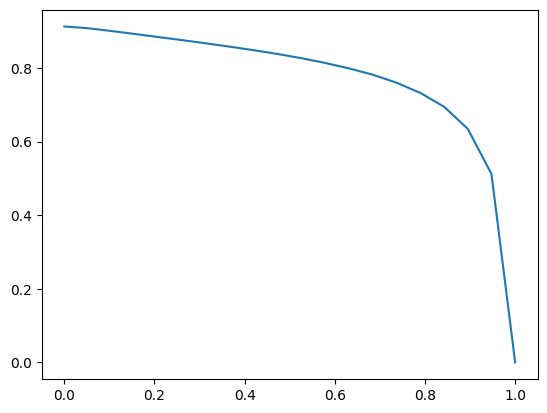

In [35]:
plt.plot(x, tns)

## TP

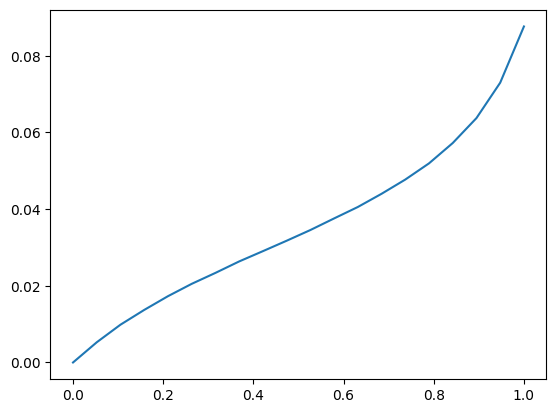

In [36]:
plt.plot(x, tps)